#BERT Model
##Final F1-Score for Test Data: 0.870819397993311
##Submission #1 Score: 0.79068
###Leaderboard position ~ 657
##Submission #2 Score: 0.79313
###Leaderboard position ~ 581
##Submission #2 Score: 0.79773
###Leaderboard position ~ 435

In [ ]:
%pip install tensorflow
%pip install --upgrade tensorflow
%pip install keras
%pip install keras-nlp
%pip install keras-hub
%pip install --upgrade keras keras-nlp keras-hub
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install transformers
%pip install --upgrade transformers
%pip install tensorflow
%pip install keras-nlp
%pip install scikit-learn
%pip install nltk
%pip install matplotlib-venn


In [2]:
import os
import sys
import importlib
import tensorflow as tf
from tensorflow import *
import keras
import keras_nlp
from keras import *
from keras.models import *
from keras_nlp import *
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss, classification_report
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

c:\Users\sarah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Initial Data Visualization

##Head & Info

In [3]:
# Load the train.csv file into a DataFrame
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')

# Display the first 5 rows of the DataFrame
display(trainDF.head())
display(testDF.head())

# Display basic information about the DataFrame
trainDF.info()
testDF.info()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


##Counts

##Displaying the most common words (Normalized) for each target category.

In [10]:
#Minor data preprocessing
#transform text to lowercase
trainDF["lowercase_text"] = trainDF["text"].str.lower()
#Filter out missing keywords
trainDF = trainDF[trainDF['keyword'].notnull()]

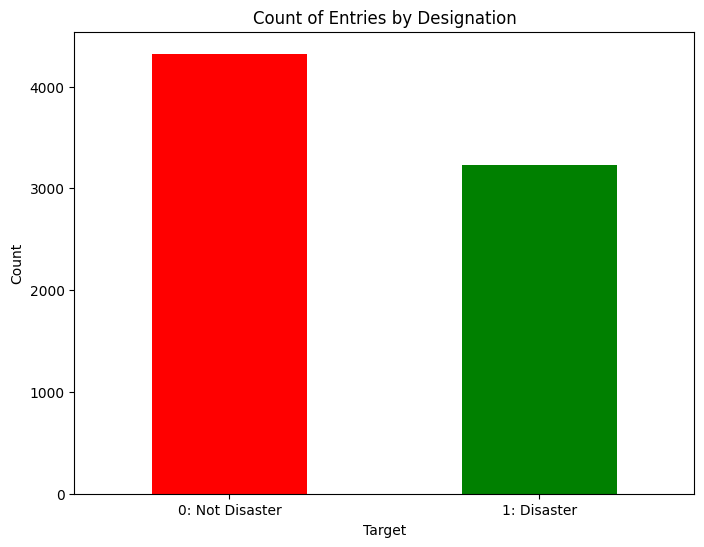

In [11]:
#Graph the counts of target designations
targetCounts = trainDF['target'].value_counts()

plt.figure(figsize=(8,6))
targetCounts.plot(kind='bar', color=['red', 'green'])
plt.title('Count of Entries by Designation')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['0: Not Disaster', '1: Disaster'], rotation=0)

plt.show()

C:\Users\sarah\AppData\Local\Temp\ipykernel_14824\2711132259.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=topKeyDF0, palette="Greens_d")


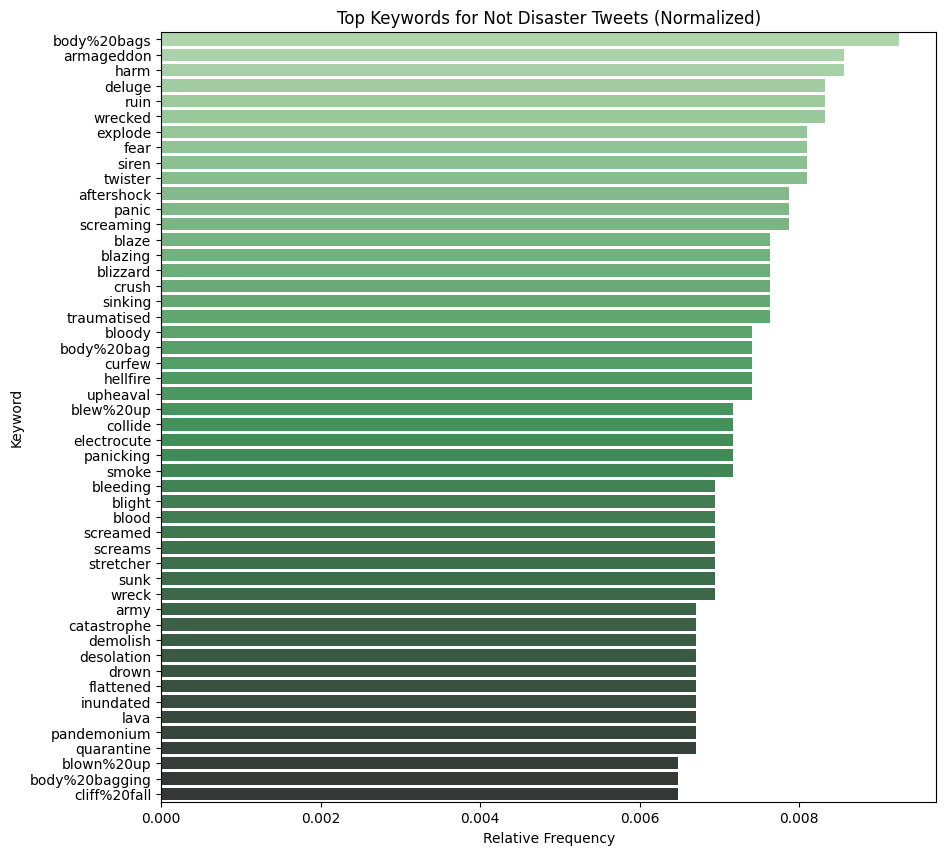

C:\Users\sarah\AppData\Local\Temp\ipykernel_14824\2711132259.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=topKeyDF1, palette="Reds_d")


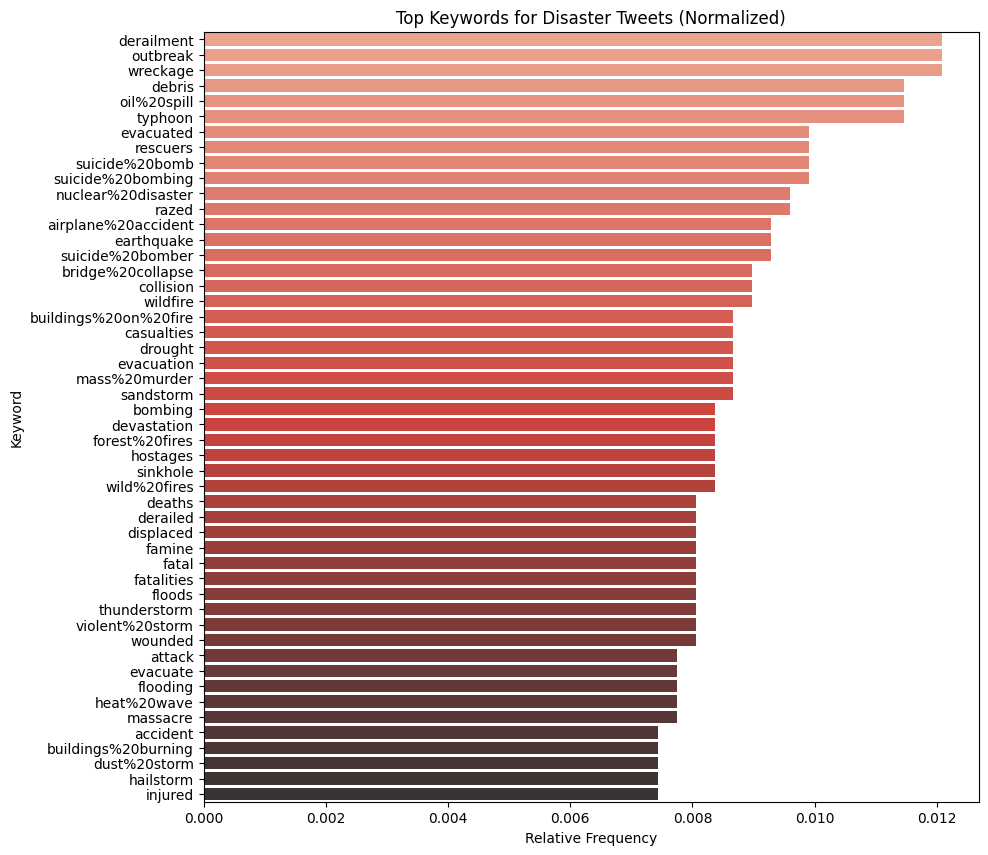

In [14]:
#Separate keywords by target
targetKeywords0 = trainDF[trainDF['target'] == 0]['keyword']
targetKeywords1 = trainDF[trainDF['target'] == 1]['keyword']

# Count keywords
topKeywords0 = Counter(targetKeywords0).most_common(50)
topKeywords1 = Counter(targetKeywords1).most_common(50)

# Normalize counts (convert to relative frequency)
total0 = len(targetKeywords0)
total1 = len(targetKeywords1)

topKeyDF0 = pd.DataFrame(topKeywords0, columns=['Keyword', 'Count'])
topKeyDF0['Frequency'] = topKeyDF0['Count'] / total0

topKeyDF1 = pd.DataFrame(topKeywords1, columns=['Keyword', 'Count'])
topKeyDF1['Frequency'] = topKeyDF1['Count'] / total1

# Plot normalized frequencies
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Keyword', data=topKeyDF0, palette="Greens_d")
plt.title('Top Keywords for Not Disaster Tweets (Normalized)')
plt.xlabel('Relative Frequency')
plt.show()

plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Keyword', data=topKeyDF1, palette="Reds_d")
plt.title('Top Keywords for Disaster Tweets (Normalized)')
plt.xlabel('Relative Frequency')
plt.show()

###Testing for vocabulary overlap in the most common words.

In [ ]:
#Filter out missing keywords
filterDF = trainDF[trainDF['keyword'].notnull()]

#Separate keywords by target
targetKeywords0 = filterDF[filterDF['target'] == 0]['keyword']
targetKeywords1 = filterDF[filterDF['target'] == 1]['keyword']

#Count keywords
topKeywords0 = Counter(targetKeywords0).most_common(50)
topKeywords1 = Counter(targetKeywords1).most_common(50)

#Convert to sets of keywords
set0 = set([kw for kw, _ in topKeywords0])
set1 = set([kw for kw, _ in topKeywords1])

# Plot Venn diagram
plt.figure(figsize=(10, 10))
venn2([set0, set1], set_labels=('0: Not Disaster', '1: Disaster'))
plt.title('Overlap of Top Keywords in Tweets')
plt.show()
#show overlapping words
print("Overlap keywords:", set0.intersection(set1))

####There is no overlap for the first 50 words. Testing for overlap in the 100 top words.

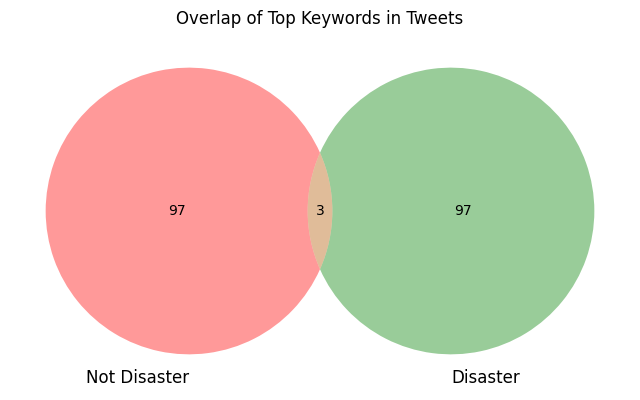

Overlap keywords: {'damage', 'drowned', 'windstorm'}


In [29]:
# Filter out missing keywords
filterDF = trainDF[trainDF['keyword'].notnull()]

# Separate keywords by target
targetKeywords0 = filterDF[filterDF['target'] == 0]['keyword']
targetKeywords1 = filterDF[filterDF['target'] == 1]['keyword']

# Count keywords
topKeywords0 = Counter(targetKeywords0).most_common(100)
topKeywords1 = Counter(targetKeywords1).most_common(100)

# Convert to sets of keywords
set0 = set([kw for kw, _ in topKeywords0])
set1 = set([kw for kw, _ in topKeywords1])

# Plot Venn diagram
plt.figure(figsize=(8, 6))
venn2([set0, set1], set_labels=('Not Disaster', 'Disaster'))
plt.title('Overlap of Top Keywords in Tweets')
plt.show()
#show overlapping words
print("Overlap keywords:", set0.intersection(set1))

##Testing the same for hashtags

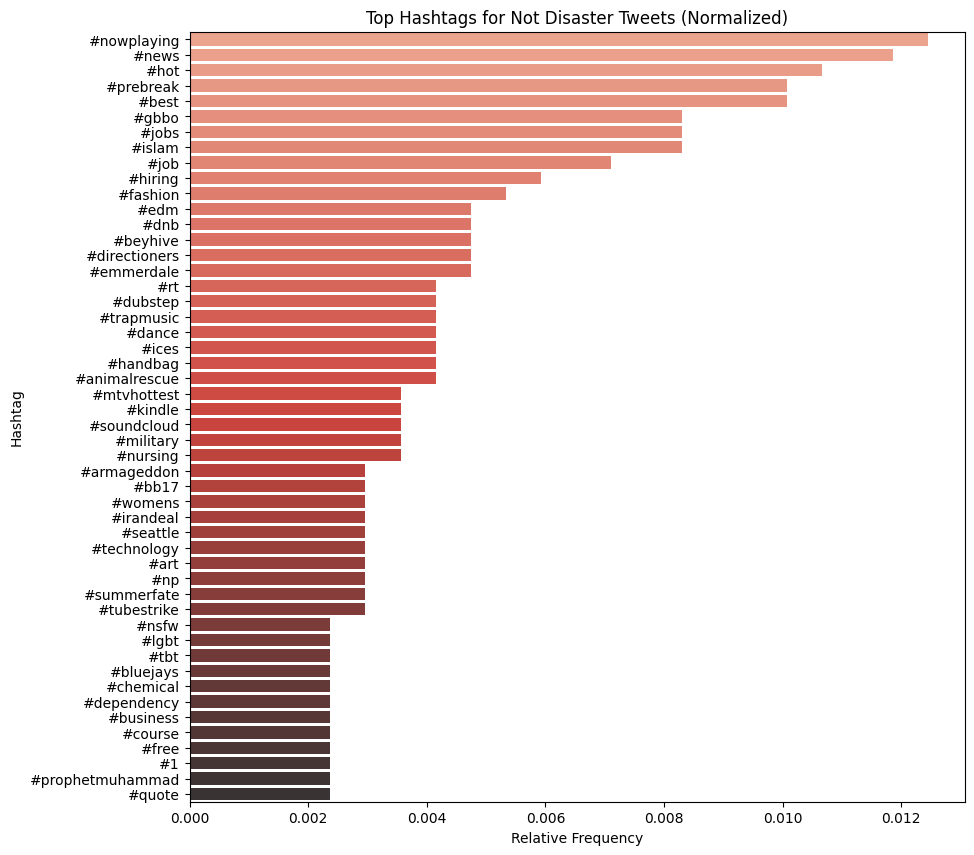

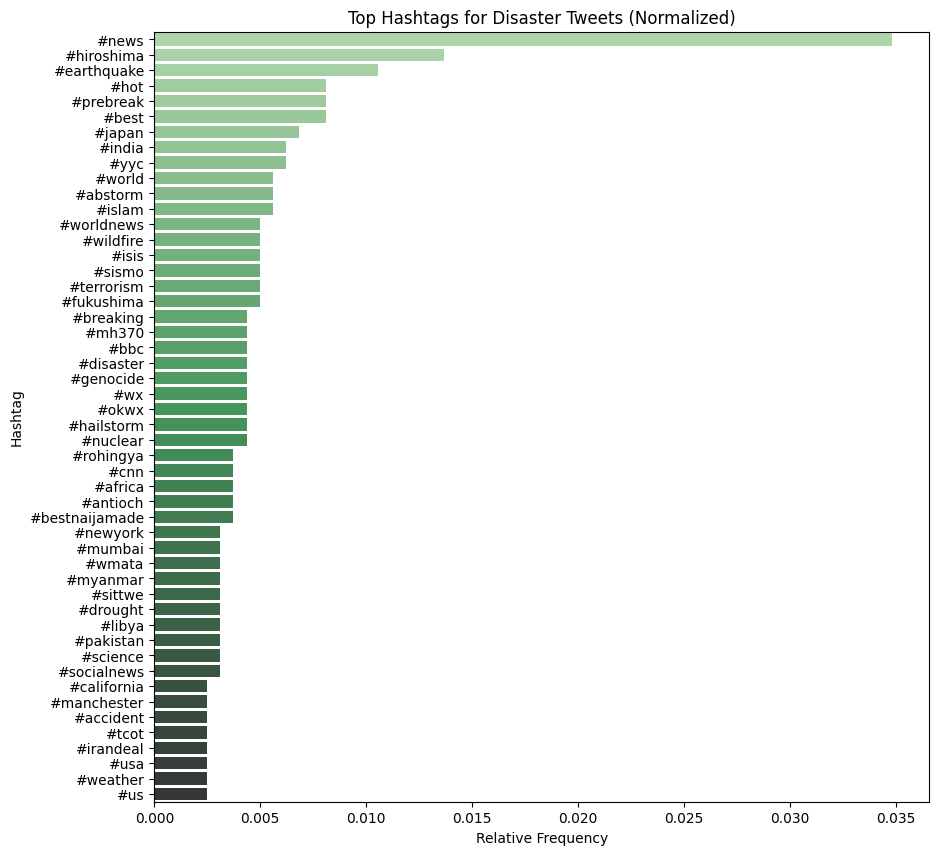

In [31]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

trainDF['hashtags'] = trainDF['lowercase_text'].apply(extract_hashtags)
targetHash0 = [hashtag for hashtags, target in zip(trainDF['hashtags'], trainDF['target']) if target == 0 for hashtag in hashtags]
targetHash1 = [hashtag for hashtags, target in zip(trainDF['hashtags'], trainDF['target']) if target == 1 for hashtag in hashtags]
#top 50 hashtags
topHash0 = Counter(targetHash0).most_common(50)
topHash1 = Counter(targetHash1).most_common(50)

#Create top hashtag DataFrames
topHashDF0 = pd.DataFrame(topHash0, columns=['Hashtag', 'Count'])
topHashDF1 = pd.DataFrame(topHash1, columns=['Hashtag', 'Count'])

# Normalize counts
total0 = len(targetHash0)
total1 = len(targetHash1)

#top hashtag frequencies DataFrames
topHashDF0['Frequency'] = topHashDF0['Count'] / total0
topHashDF1['Frequency'] = topHashDF1['Count'] / total1

#Plot normalized frequencies
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Hashtag', hue='Hashtag', data=topHashDF0, palette="Reds_d", legend=False)
plt.title('Top Hashtags for Not Disaster Tweets (Normalized)')
plt.xlabel('Relative Frequency')
plt.show()

plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Hashtag', hue='Hashtag', data=topHashDF1, palette="Greens_d", legend=False)
plt.title('Top Hashtags for Disaster Tweets (Normalized)')
plt.xlabel('Relative Frequency')
plt.show()

###Testing for overlap of the 50 most common hashtags

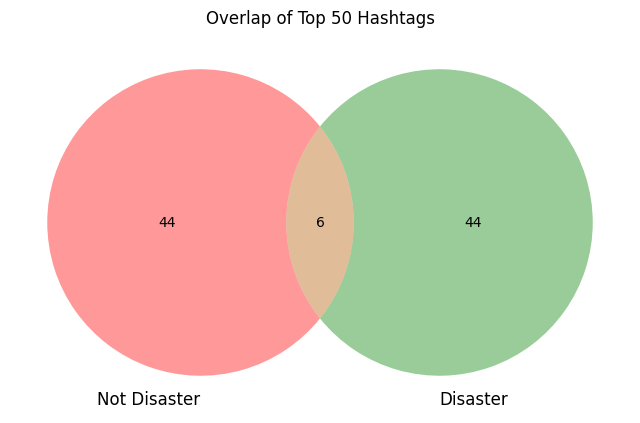

Overlap hashtags: {'#best', '#prebreak', '#irandeal', '#islam', '#news', '#hot'}


In [32]:
#Get the sets of top 50 hashtags
set_hashtags0 = set(topHashDF0['Hashtag'])
set_hashtags1 = set(topHashDF1['Hashtag'])

#Plot Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_hashtags0, set_hashtags1], set_labels=('Not Disaster', 'Disaster'))
plt.title('Overlap of Top 50 Hashtags')
plt.show()

#Show overlapping hashtags
print("Overlap hashtags:", set_hashtags0.intersection(set_hashtags1))

In [ ]:
#top 100 hashtags
topBigHash0 = Counter(targetHash0).most_common(100)
topBigHash1 = Counter(targetHash1).most_common(100)
#Create top hashtag DataFrames
topBigHashDF0 = pd.DataFrame(topBigHash0, columns=['Hashtag', 'Count'])
topBigHashDF1 = pd.DataFrame(topBigHash1, columns=['Hashtag', 'Count'])

#Get the sets of top 50 hashtags
set_BigHashtags0 = set(topBigHashDF0['Hashtag'])
set_BigHashtags1 = set(topBigHashDF1['Hashtag'])

#Plot Venn diagram
plt.figure(figsize=(10,10))
venn2([set_BigHashtags0, set_BigHashtags1], set_labels=('Not Disaster', 'Disaster'))
plt.title('Overlap of Top 50 Hashtags')
plt.show()

#Show overlapping hashtags
print("Overlap hashtags:", set_BigHashtags0.intersection(set_BigHashtags1))

####Here we can see that there is alot more overlap between the most common hashtags than with keywords.

##Preprocessing

###Check for and handle duplicats

In [16]:
duplicateText = trainDF[trainDF["text"].duplicated(keep=False)]
uniqueTargets = duplicateText.groupby('text').filter(lambda x: x["target"].nunique() != 1)
indices = uniqueTargets.index.tolist()
for index in indices[:2]:
    print(trainDF.loc[index])

id                                       881
keyword                         bioterrorism
location                                 NaN
text              To fight bioterrorism sir.
target                                     1
lowercase_text    to fight bioterrorism sir.
Name: 610, dtype: object
id                                       898
keyword                         bioterrorism
location                                 NaN
text              To fight bioterrorism sir.
target                                     0
lowercase_text    to fight bioterrorism sir.
Name: 624, dtype: object


###Cleaning

In [17]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def remove_stopwords(text):
    words = [word for word in text.split(" ") if word not in stop]
    return " ".join(words)
def clean_text(text):
  text = text.lower()
  text = remove_url(text)
  text = remove_html(text)
  text = remove_punctuation(text)
  text = remove_numbers(text)
  text = remove_empty_spaces(text)
  text = remove_stopwords(text)
  return text
example = trainDF["text"].iloc[0]
print("Before cleaning:", example)
print("After cleaning: ", clean_text(example))

Before cleaning: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
After cleaning:  bbcmtd wholesale markets ablaze


In [18]:
trainDF["cleaned_text"] = trainDF["text"].apply(clean_text)
testDF["cleaned_text"] = testDF["text"].apply(clean_text)

Vocabulary size (Not Disaster, target=0): 11930
Vocabulary size (Disaster, target=1): 8748
Overlap size: 3880
Example overlap words: ['efforts',
 'bp',
 'network',
 'scares',
 'player',
 'clouds',
 'way',
 'batting',
 'bradleybrad',
 'shouldnt',
 'offersgo',
 'stops',
 'iran',
 'memes',
 'chesttorso',
 'empty',
 'games',
 'boston',
 'tote',
 'pandemonium',
 'holmgren',
 'chile',
 'scheme',
 'return',
 'depth',
 'bay',
 'link',
 'letters',
 'bully',
 'israel']
Example unique to target=0: ['alrasyiditurasya',
 'barbitwins',
 'metrotown',
 'nprfreshair',
 'psychologist',
 'camera',
 'etisalat',
 'wen',
 'flechadas',
 'fur',
 'drinks',
 'deemed',
 'katiekatcubs',
 'protein',
 'isea',
 'ab',
 'err',
 'acmilan',
 'garbage',
 'caixxumsos']
Example unique to target=1: ['iembothfo',
 'bland',
 'lauded',
 'newswatch',
 'exc',
 'repatriating',
 'signal',
 'contig',
 'kowing',
 'tepat',
 'deputy',
 'livemint',
 'spsgsp',
 'pacific',
 'edna',
 'aleisstokes',
 'peninsula',
 'galactics',
 'declarat',

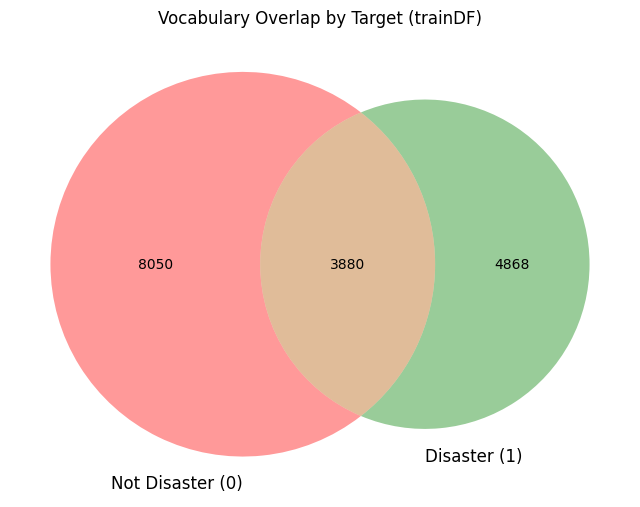

In [24]:
# Build vocabulary sets from trainDF (using cleaned_text)
def _vocab_from_series(series):
    toks = set()
    for txt in series.dropna().astype(str):
        # cleaned_text already lowercased and punctuation/stopwords removed in earlier cell
        for tok in txt.split():
            tok = tok.strip()
            if tok:
                toks.add(tok)
    return toks

vocab_target0 = _vocab_from_series(trainDF.loc[trainDF['target'] == 0, "cleaned_text"])
vocab_target1 = _vocab_from_series(trainDF.loc[trainDF['target'] == 1, "cleaned_text"])

# Print basic stats
print(f"Vocabulary size (Not Disaster, target=0): {len(vocab_target0)}")
print(f"Vocabulary size (Disaster, target=1): {len(vocab_target1)}")
print(f"Overlap size: {len(vocab_target0 & vocab_target1)}")
print("Example overlap words:", list(vocab_target0 & vocab_target1)[:30])
print("Example unique to target=0:", list(vocab_target0 - vocab_target1)[:20])
print("Example unique to target=1:", list(vocab_target1 - vocab_target0)[:20])

# Venn diagram of the two vocabularies
plt.figure(figsize=(8, 8))
venn2([vocab_target0, vocab_target1], set_labels=('Not Disaster (0)', 'Disaster (1)'))
plt.title("Vocabulary Overlap by Target (trainDF)")
plt.show()

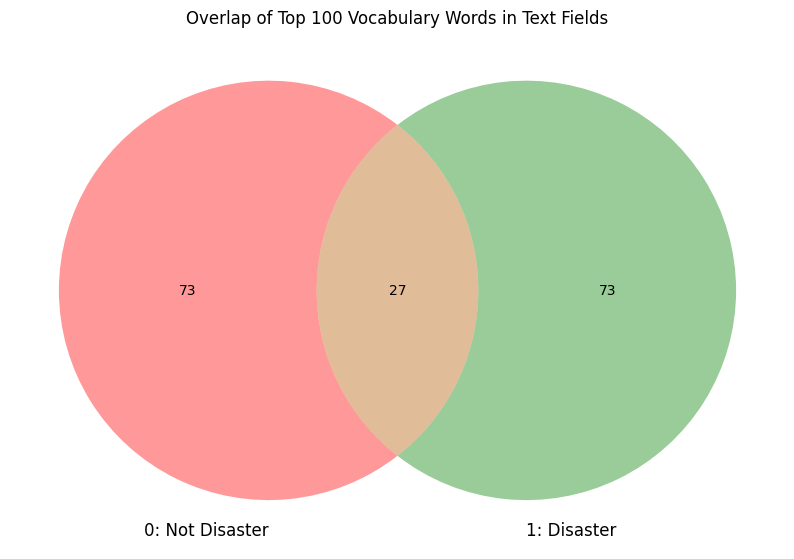

Overlap tokens: ['amp',
 'back',
 'burning',
 'could',
 'dont',
 'emergency',
 'fire',
 'first',
 'get',
 'im',
 'like',
 'man',
 'may',
 'new',
 'news',
 'one',
 'people',
 'rt',
 'say',
 'still',
 'time',
 'today',
 'us',
 'via',
 'video',
 'world',
 'would']


In [28]:
# top 100 vocabulary words in text fields (by frequency per target)
def _token_counts_for_target(df, target):
	cnt = Counter()
	texts = df.loc[df['target'] == target, 'cleaned_text'].dropna().astype(str)
	for t in texts:
		for tok in t.split():
			tok = tok.strip()
			if tok:
				cnt[tok] += 1
	return cnt

counter0 = _token_counts_for_target(trainDF, 0)
counter1 = _token_counts_for_target(trainDF, 1)

topVocab0 = counter0.most_common(100)
topVocab1 = counter1.most_common(100)

# Create top Vocabulary DataFrames
topVocabDF0 = pd.DataFrame(topVocab0, columns=["token", "Count"])
topVocabDF1 = pd.DataFrame(topVocab1, columns=["token", "Count"])

# Prepare sets for Venn diagram
set0 = set([tok for tok, _ in topVocab0])
set1 = set([tok for tok, _ in topVocab1])

# Plot Venn diagram
plt.figure(figsize=(10,10))
venn2([set0, set1], set_labels=('0: Not Disaster', '1: Disaster'))
plt.title('Overlap of Top 100 Vocabulary Words in Text Fields')
plt.show()

# Show overlapping tokens
print("Overlap tokens:", sorted(list(set0 & set1)))

In [34]:
#Create a unified set named significant_features
significant_features = set()
for feature_list in [topKeywords0, topKeywords1, topHash0, topHash1, topVocab0, topVocab1]:
    for term, count in feature_list:
        significant_features.add(term)

#Ensure lowercase_text exists for both dataframes
if "lowercase_text" not in testDF.columns:
    testDF["lowercase_text"] = testDF["text"].str.lower()
if "lowercase_text" not in trainDF.columns:
    trainDF["lowercase_text"] = trainDF["text"].str.lower()

#Define extract_hashtags (works on lowercase text)
def extract_hashtags(text):
    if not isinstance(text, str):
        return []
    return re.findall(r'#\w+', text)

#Ensure both dataframes have a hashtags column
#Define a shared normalizer so it's available for both testDF and trainDF
def _normalize_hashtags(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return extract_hashtags(x)
    #handle numpy arrays / pandas sequences
    try:
        if hasattr(x, "tolist"):
            lst = list(x)
            return [h for h in lst if isinstance(h, str)]
    except Exception:
        pass
    return extract_hashtags(x)

if "hashtags" not in testDF.columns:
    testDF["hashtags"] = testDF["lowercase_text"].apply(extract_hashtags)
else:
    testDF["hashtags"] = testDF["hashtags"].apply(_normalize_hashtags)

if "hashtags" not in trainDF.columns:
    trainDF["hashtags"] = trainDF["lowercase_text"].apply(extract_hashtags)
else:
    trainDF["hashtags"] = trainDF["hashtags"].apply(_normalize_hashtags)

#Define helper to detect missing / empty values robustly
def _is_missing_or_empty(x):
    if x is None:
        return True
    #numpy/pandas nan
    try:
        if isinstance(x, float) and np.isnan(x):
            return True
    except Exception:
        pass
    #empty list/tuple/set
    if isinstance(x, (list, tuple, set)):
        return len(x) == 0
    #numpy array or pandas Series/Index
    if hasattr(x, "size"):
        try:
            return int(np.asarray(x).size) == 0
        except Exception:
            return False
    return False

#Define augment_text function that is robust if columns are missing / NaN
def augment_text(row):
    extra_features = []
    #Safe access to Vocabulary
    vocab = row.get("cleaned_text") if "cleaned_text" in row.index else None
    if pd.notna(vocab) and isinstance(vocab, str) and vocab in significant_features:
        extra_features.append(vocab)

    #Safe access to keyword
    keyword = row.get("keyword") if "keyword" in row.index else None
    if pd.notna(keyword) and isinstance(keyword, str) and keyword in significant_features:
        extra_features.append(keyword)

    #Safe access to hashtags; fall back to extracting from lowercase_text if needed
    hashtags = row.get("hashtags") if "hashtags" in row.index else None

    #If hashtags is a single string, extract hashtags from it
    if isinstance(hashtags, str):
        hashtags = extract_hashtags(hashtags)

    if _is_missing_or_empty(hashtags):
        text_for_tags = row.get("lowercase_text") or row.get("text") or ""
        hashtags = extract_hashtags(text_for_tags)

    #Normalize hashtags into a plain Python list
    if isinstance(hashtags, (np.ndarray, pd.Series)):
        hashtags = list(hashtags)
    elif not isinstance(hashtags, list):
        try:
            hashtags = list(hashtags)
        except Exception:
            hashtags = []

    for hashtag in hashtags:
        if isinstance(hashtag, str) and hashtag in significant_features:
            extra_features.append(hashtag)

    #Base text to prepend to
    base_text = row.get("cleaned_text") or row.get("text") or ""

    prefix = " ".join(extra_features)
    return (prefix + " " + base_text).strip() if prefix else base_text

#Apply augment_text to trainDF and testDF (returns a Series of augmented strings)
X = trainDF.apply(augment_text, axis=1)
X_test = testDF.apply(augment_text, axis=1)

#Print the first 5 rows of the updated X
print(X.head())

31               ablaze bbcmtd wholesale markets ablaze
32           ablaze #rt always try bring heavy metal rt
33    ablaze africanbaze breaking newsnigeria flag s...
34                             ablaze crying set ablaze
35          ablaze plus side look sky last night ablaze
dtype: object


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

class SklearnWrapper:
    def __init__(self):
        self.pipeline = make_pipeline(
            TfidfVectorizer(max_features=1000000, ngram_range=(1, 3),sublinear_tf=True, stop_words='english' ),
            LogisticRegression(max_iter=10000, solver="lbfgs")
        )
        self._classes_ = None

    def compile(self, loss=None, optimizer=None, metrics=None, **kwargs):
        # Accept Keras-style arguments but ignore them
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        return None

    def fit(self, x, y, batch_size=None, epochs=None,
            validation_data=None, callbacks=None, **kwargs):
        X = list(x)
        y_list = list(y)
        self.pipeline.fit(X, y_list)
        try:
            self._classes_ = self.pipeline.named_steps['logisticregression'].classes_
        except Exception:
            self._classes_ = None

        # Dummy history object to mimic Keras
        class History:
            def __init__(self):
                self.history = {
                    "loss": [],
                    "val_loss": [],
                    "accuracy": [],
                    "val_accuracy": []
                }
        return History()

    def predict(self, x):
        X = list(x)
        if hasattr(self.pipeline, "predict_proba"):
            return self.pipeline.predict_proba(X)
        preds = self.pipeline.predict(X)
        if len(set(preds)) <= 2:
            return np.vstack([1 - preds, preds]).T
        return np.eye(len(set(preds)))[preds]

    def evaluate(self, x, y):
        X = list(x)
        y_list = list(y)
        preds_proba = self.predict(X)
        preds = np.argmax(preds_proba, axis=1)

        acc = accuracy_score(y_list, preds)
        try:
            loss = log_loss(y_list, preds_proba)
        except Exception:
            loss = None
        return loss, acc

# Prepare train/validation split (create X_train, X_val, y_train, y_val) if not defined
if 'X' not in globals():
    raise NameError("X (augmented training texts) not found. Run the cell that creates X before this cell.")
if 'trainDF' not in globals():
    raise NameError("trainDF not found. Ensure the training DataFrame exists.")

# y labels from trainDF
y = trainDF['target']

# Only create the split if variables are not already present
if not all(name in globals() for name in ('X_train', 'X_val', 'y_train', 'y_val')):
    # X is a pandas Series created previously (augmented text)
    X_series = X
    X_train, X_val, y_train, y_val = train_test_split(
        X_series, y, test_size=0.1, random_state=42, stratify=y
    )

# Initialize classifier and early_stopping
classifier = SklearnWrapper()
early_stopping = None

# Compile and fit just like Keras
classifier.compile(
    loss="sparse_categorical_crossentropy",  # accepted but ignored
    optimizer="adam",                        # accepted but ignored
    metrics=["accuracy"]
)

history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=early_stopping
)

# Evaluate on validation set
val_loss, val_acc = classifier.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")


Validation loss: 0.4787, Validation accuracy: 0.8069


In [ ]:
y_train_pred = classifier.predict(X_train)
# use a valid colormap name and avoid shadowing the display() builtin
disp = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_train_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap='Greens'
)
disp.ax_.set_title("Confusion Matrix: Training Dataset")

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

In [ ]:
y_val_pred = classifier.predict(X_val)

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_val_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Confusion Matrix: Validation Dataset")

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_val_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

In [ ]:
#Create submission.csv with predictions for the test set
#Get predictions from the trained classifier (robust to different output shapes)
probs_or_preds = classifier.predict(X_test)

if isinstance(probs_or_preds, np.ndarray):
    if probs_or_preds.ndim == 1:
        preds = (probs_or_preds > 0.5).astype(int)
    elif probs_or_preds.shape[1] == 1:
        preds = (probs_or_preds.ravel() > 0.5).astype(int)
    else:
        preds = np.argmax(probs_or_preds, axis=1)
else:
    # Fallback: try to convert to numpy array then handle
    arr = np.asarray(probs_or_preds)
    if arr.ndim == 1:
        preds = (arr > 0.5).astype(int)
    elif arr.shape[1] == 1:
        preds = (arr.ravel() > 0.5).astype(int)
    else:
        preds = np.argmax(arr, axis=1)

# Ensure length matches testDF
preds = np.asarray(preds).astype(int).reshape(-1)
if preds.shape[0] != testDF.shape[0]:
    # Align by index if X_test kept original index
    preds = pd.Series(preds, index=X_test.index).reindex(testDF.index).fillna(0).astype(int).values

submission_df = pd.DataFrame({
    "id": testDF["id"].astype(int).values,
    "target": preds
})

submission_df.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission_df), "rows")
print(submission_df.head())